# Data Processing

In [11]:
from statistics import median
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import os
import matplotlib as mpl
import seaborn as sb

feature_list_xlsx = ["CZA","CZB","CZD","CZH","CZM","CZV","PMC","TRF"]
feature_list_csv = ["EDU","MHI","Public_Assistance_Rate","median_gross_rent","median_monthly_housing_costs",
"perc_below_poverty", "perc_college_grad","perc_hs_grad","perc_insured","perc_rental_housing","unemployment","work_travel_time"]
# left out "business_licenses"
path = os.path.join(os.getcwd(),'data_clean')
feature_values = pd.read_excel(os.path.join(path,'TRF_2016.xlsx'))
geoid = feature_values['GEOID']
dataframes = {}

# Read in feature values
for year in range(2016, 2020):
    df_dict = {}
    df_dict['GEOID'] = geoid
    df_dict['YEAR'] = year
    for feature in feature_list_xlsx:
        file_name = feature + "_" + str(year) + '.xlsx'
        feature_values = pd.read_excel(os.path.join(path,file_name))
        df_dict[feature] = feature_values[file_name[:-5]]
    for feature in feature_list_csv:
        file_name = feature + "_" + str(year) + '.csv'
        feature_values = pd.read_csv(os.path.join(path,file_name))
        df_dict[feature] = feature_values[file_name[:-4]]
    dataframes[year] = pd.DataFrame(df_dict)

feature_values = pd.concat(dataframes.values(), ignore_index=True)
feature_values = feature_values.apply(pd.to_numeric, errors='coerce')

# Read in house values
house_values = pd.read_csv(os.path.join(path,'home_value.csv'))
renamed_geoid = []
for row in house_values['GEOID']:
    tract_num = (row.split(',')[0]).replace("Census Tract ",'')
    if ('.' in tract_num):
        tract_num = '17031' + tract_num.replace('.','')
    else:
        tract_num = '17031' + tract_num + '00'
    renamed_geoid.append(int(tract_num))
house_values['GEOID'] = renamed_geoid

# Create dataframe of feature and outcome values
df = pd.merge(house_values, feature_values, on=['YEAR','GEOID'])
col_dict = {'CZA': 'violent_crime',"CZB":"burglary","CZD":"drug_abuse",'CZH': 'aggravated_assault', "CZM": "major_crime", 
'CZV': 'homicide',"PMC":"pollution", 'TRF': 'traffic_intensity', 'EDU': 'college_enrolled','MHI': 'household_income', 
"Public_Assistance_Rate":"public_assistance"}

feature_list = col_dict.values()
# feature_list = feature_list_xlsx + feature_list_csv

df = df.rename(columns = col_dict)
print(df)

            GEOID  YEAR  house_value  violent_crime  burglary  drug_abuse  \
0     17031100100  2016       267200            5.0      14.0         4.0   
1     17031100200  2016       280300            5.0      13.0         1.0   
2     17031100300  2016       339600            6.0       9.0        16.0   
3     17031100400  2016       327700            0.0      11.0         0.0   
4     17031100500  2016       317200            1.0      17.0         1.0   
...           ...   ...          ...            ...       ...         ...   
2552  17031843500  2019       178700           18.0      10.0        13.0   
2553  17031843600  2019       266500            4.0      20.0         5.0   
2554  17031843700  2019       499700            9.0       0.0         6.0   
2555  17031843800  2019       171900           47.0       4.0        10.0   
2556  17031843900  2019       105700            9.0       0.0       106.0   

      aggravated_assault  major_crime  homicide  pollution  ...  \
0       

# Summary Statistics

In [12]:
df = df.drop('GEOID',1)
print(df.head())
print(df.describe())
print(df.dtypes)

   YEAR  house_value  violent_crime  burglary  drug_abuse  aggravated_assault  \
0  2016       267200            5.0      14.0         4.0                 0.0   
1  2016       280300            5.0      13.0         1.0                 0.0   
2  2016       339600            6.0       9.0        16.0                 0.0   
3  2016       327700            0.0      11.0         0.0                 0.0   
4  2016       317200            1.0      17.0         1.0                 0.0   

   major_crime  homicide  pollution  traffic_intensity  ...  \
0         76.0      10.0  11.828811         605.408171  ...   
1         90.0       9.0  11.801161         152.776736  ...   
2         77.0       6.0  11.836691        1223.176635  ...   
3         33.0       0.0  11.853769        1865.990705  ...   
4         82.0       4.0  11.902991        1962.186822  ...   

   public_assistance  median_gross_rent  median_monthly_housing_costs  \
0          30.149254             1087.0                      

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [13]:
print(df.dtypes)

YEAR                              int64
house_value                       int64
violent_crime                   float64
burglary                        float64
drug_abuse                      float64
aggravated_assault              float64
major_crime                     float64
homicide                        float64
pollution                       float64
traffic_intensity               float64
college_enrolled                float64
household_income                float64
public_assistance               float64
median_gross_rent               float64
median_monthly_housing_costs    float64
perc_below_poverty              float64
perc_college_grad               float64
perc_hs_grad                    float64
perc_insured                    float64
perc_rental_housing             float64
unemployment                    float64
work_travel_time                float64
dtype: object


The dataframe comprises 2557 observations, where each observation contains the median house value (outcome variable) and 9 feature variables for a given census tract and year. The variables will be split 80:20, so that 80% of the data is in the training dataset and 20% is in the testing dataset.

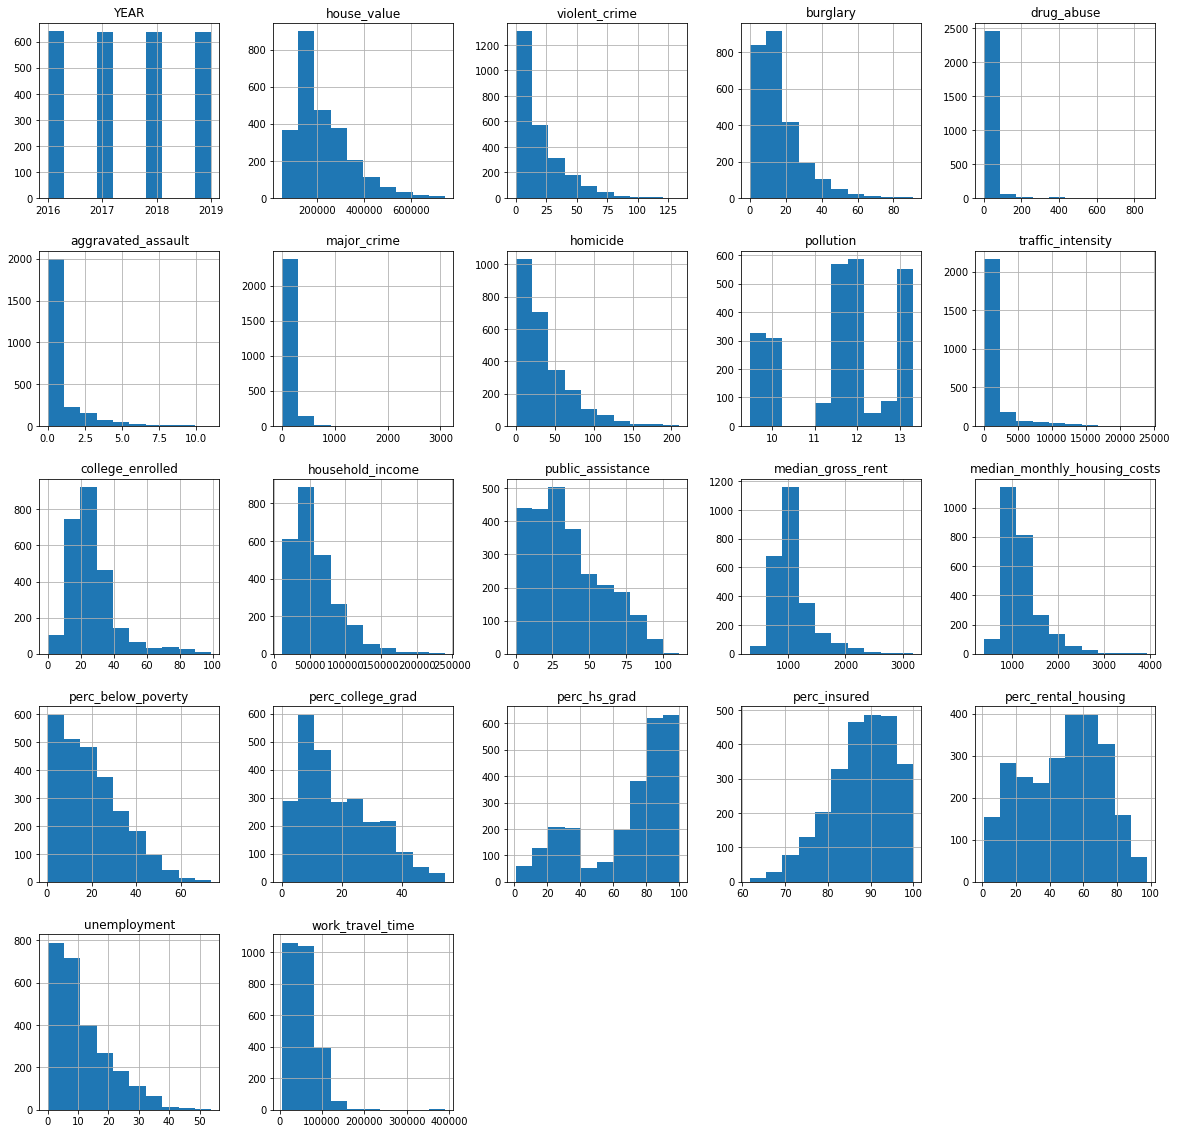

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

df.hist(figsize=(20,20))
plt.show()

From plotting the distribution of the feature values, we observe that features vary significantly in scale, so we will be normalizing the feature parameters. We can also observe that features such as assault and traffic instensity are significantly skewed with most values being in the lowest value bucket, as such, we have concerns that there may no be enough variation in those features to be valuable for the model. We fortunately do not observe any outliers that would need to be excluded.

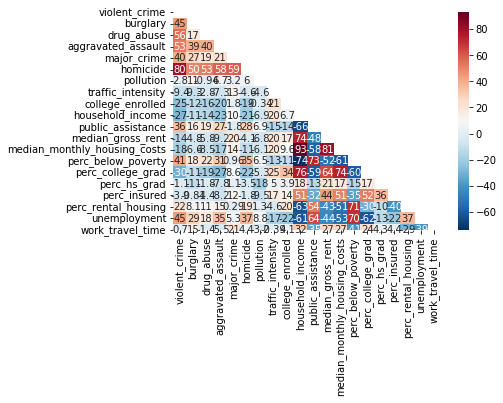

In [15]:
corr_matrix = df.corr()
print(corr_matrix["house_value"].sort_values(ascending=False))
mask = np.zeros_like(df.iloc[:,2:].corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True
sb.heatmap(df.iloc[:,2:].corr()*100, cmap='RdBu_r', annot = True, mask=mask)

Based on the heat map of the correlations of features, we can see that there is a positive correlation between housing price and median household income for an area, as well as the percent of the population enrolled in college. We can also observe a strong negative correlation between household price and unemployment levels and crime levels in the area. There is strong correlation between the crime features, which my make it worth combining them into a single feature.

# Feature Engineering

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

X = df.drop('house_value', 1)
y = df['house_value']

imputer = SimpleImputer(strategy="median")

# Replace NA feature values with feature median
for feature in feature_list:
    col_ave = X[feature].median()
    X[feature].fillna(value = col_ave, inplace = True)

# Convert categorical variables to factors
X['YEAR'], _ = pd.factorize(df['YEAR'], sort=True)

# Attempted combining variables, but models did not change from collapsing crime measures, and deterioriated from collapsing crime and poverty measures
# Collapse crime and poverty measures into one variable each
# X['crime_rate'] = X['violent_crime'] + X['aggravated_assault'] + X['homicide']
# X = X.drop(['violent_crime','aggravated_assault','homicide'],1)

# X['poverty_index'] = X['poverty_rate'] + X['rental_rate'] + X['unemploy_rate']
# X = X.drop(['poverty_rate','rental_rate','unemploy_rate'],1)

#feature_list = ['traffic_intensity', 'college_rate','household_income','poverty_rate','rental_rate','unemploy_rate','crime_rate']

# Scale all features
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
X_trans = (num_pipeline.fit_transform(X))

train_x, test_x, train_y, test_y = train_test_split(X_trans, y.to_numpy(), test_size=0.2, random_state=123)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


# Model Training

### Linear Regression

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

lin_reg = LinearRegression()
lin_reg.fit(train_x, train_y)
lin_predictions = lin_reg.predict(train_x) 
lin_mse = mean_squared_error(train_y, lin_predictions)  
lin_rmse = np.sqrt(lin_mse) 
print(lin_rmse)
#print(mean_absolute_error(train_y, lin_predictions))

# Cross validation
lin_scores = cross_val_score(lin_reg, train_x, train_y, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

76203.0643812887
Scores: [70229.72040209 74841.57066126 74725.3343602  80074.99405005
 72351.5196196  72227.32348563 77682.70267329 93246.32195175
 83530.15882463 73367.40642568]
Mean: 77227.70524541821
Standard deviation: 6551.650781642087


### Decision Trees

In [19]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=123)
tree_reg.fit(train_x, train_y)
dt_predictions = tree_reg.predict(train_x)
scores = cross_val_score(tree_reg, train_x, train_y, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Scores: [84666.20571541 76043.42725883 85328.43862995 71405.40732411
 77079.28607261 92736.56078313 78043.07005951 99290.24817349
 84286.47025844 84561.29346776]
Mean: 83344.04077432318
Standard deviation: 7834.118733585584


### Support Vector Machine

In [20]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(train_x, train_y)
svm_predictions = svm_reg.predict(train_x)
svm_mse = mean_squared_error(train_y, svm_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

117609.79490111125

### Random Forest

In [21]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=123)
forest_reg.fit(train_x, train_y)
rf_predictions = forest_reg.predict(train_x) 
forest_mse = mean_squared_error(train_y, rf_predictions) 
forest_rmse = np.sqrt(forest_mse) 
print(forest_rmse)

forest_scores = cross_val_score(forest_reg, train_x, train_y,scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

20539.486049366646
Scores: [50845.72408916 51605.79470483 57052.57486222 52497.56457022
 49613.63137756 56973.99374164 50022.81576201 66954.24725428
 63815.16363767 54704.16465349]
Mean: 55408.56746530933
Standard deviation: 5621.0786147561375


### Gradient Boosted Trees

In [22]:
from sklearn.ensemble import GradientBoostingRegressor

boosted_reg = GradientBoostingRegressor(n_estimators=100, random_state=123)
boosted_reg.fit(train_x, train_y)
boosted_predictions = boosted_reg.predict(train_x) 
boosted_mse = mean_squared_error(train_y, boosted_predictions) 
boosted_rmse = np.sqrt(boosted_mse) 
print(boosted_rmse)

boosted_scores = cross_val_score(boosted_reg, train_x, train_y,scoring="neg_mean_squared_error", cv=10)
boosted_rmse_scores = np.sqrt(-boosted_scores)
display_scores(boosted_rmse_scores)

44939.145246809436
Scores: [60862.93265041 59798.33949212 60300.22432793 60017.9713228
 52478.09983485 55630.05227664 53968.35370999 73867.15454135
 64360.16466266 55965.55389355]
Mean: 59724.884671230626
Standard deviation: 5828.900766064127


# Fine Tuning Model Using Grid Search

In [23]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 30, 100, 150, 200], 'max_features': [2, 4, 6, 8, 10]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 30, 100, 150, 200], 'max_features': [2, 4, 6, 8, 10]},
  ]
forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(train_x, train_y)
print(grid_search.best_params_)

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

feature_importances = grid_search.best_estimator_.feature_importances_
print(sorted(zip(feature_importances, ['YEAR'] + feature_list_xlsx + feature_list_csv), reverse=True))


{'bootstrap': False, 'max_features': 8, 'n_estimators': 200}
77662.452215389 {'max_features': 2, 'n_estimators': 3}
61905.85908697485 {'max_features': 2, 'n_estimators': 30}
61044.91632455067 {'max_features': 2, 'n_estimators': 100}
60890.619721994546 {'max_features': 2, 'n_estimators': 150}
60773.72834202674 {'max_features': 2, 'n_estimators': 200}
73257.56341239004 {'max_features': 4, 'n_estimators': 3}
59745.99579821338 {'max_features': 4, 'n_estimators': 30}
58263.51951256214 {'max_features': 4, 'n_estimators': 100}
58165.433383965945 {'max_features': 4, 'n_estimators': 150}
58103.860659678125 {'max_features': 4, 'n_estimators': 200}
70802.652190335 {'max_features': 6, 'n_estimators': 3}
58135.47505826311 {'max_features': 6, 'n_estimators': 30}
57332.873108166874 {'max_features': 6, 'n_estimators': 100}
57330.68905727177 {'max_features': 6, 'n_estimators': 150}
57076.49156480976 {'max_features': 6, 'n_estimators': 200}
68808.0146666718 {'max_features': 8, 'n_estimators': 3}
57990.7

# Model Evaluation

In [25]:
final_model = grid_search.best_estimator_
final_predictions = final_model.predict(test_x)

final_mse = mean_squared_error(test_y, final_predictions)
final_rmse = np.sqrt(final_mse)
print("rmse:", final_rmse)
print("R^2:", r2_score(test_y, final_predictions))
print("MAE:", mean_absolute_error(test_y, final_predictions))

# Computing 95% confidence interval
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - test_y) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

rmse: 57314.90290772355
R^2: 0.7504427533450836
MAE: 35221.8837890625


array([48353.52873273, 65053.30467959])